# 0. Data Pre-Processing and EDA

Overview:
- This notebook will perform image pre-processing and EDA to ensure standard inputs to the eventual machine learning classifiers
- The process will include the following:
    - Size and Channels standardization
    - Normalization of all images
    - Ensuring all images are of the same data-type

### 0. Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv

### 1. Load all images, plot shape distribution, and show example images

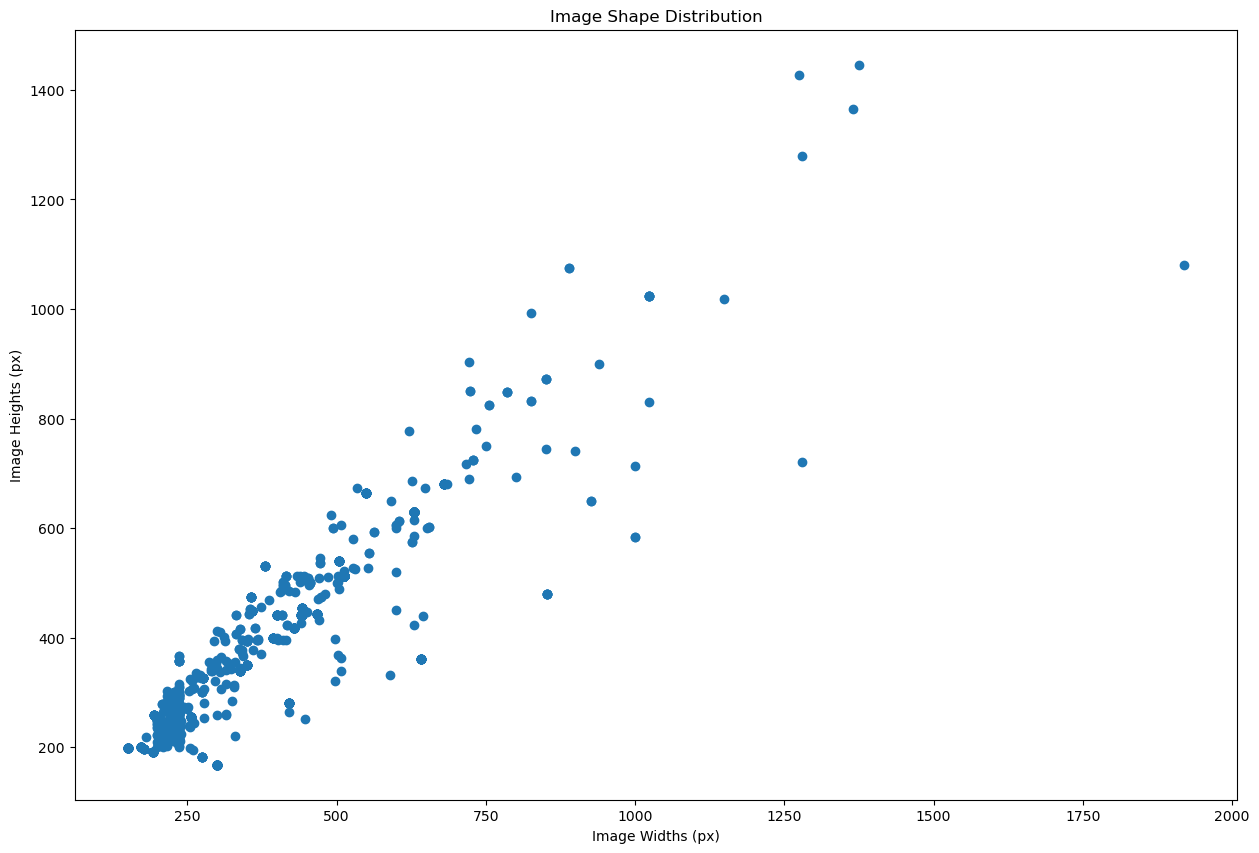

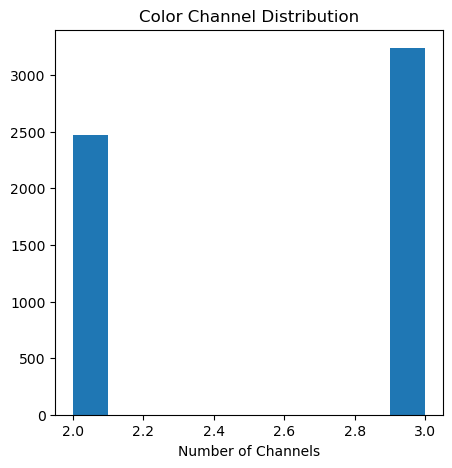

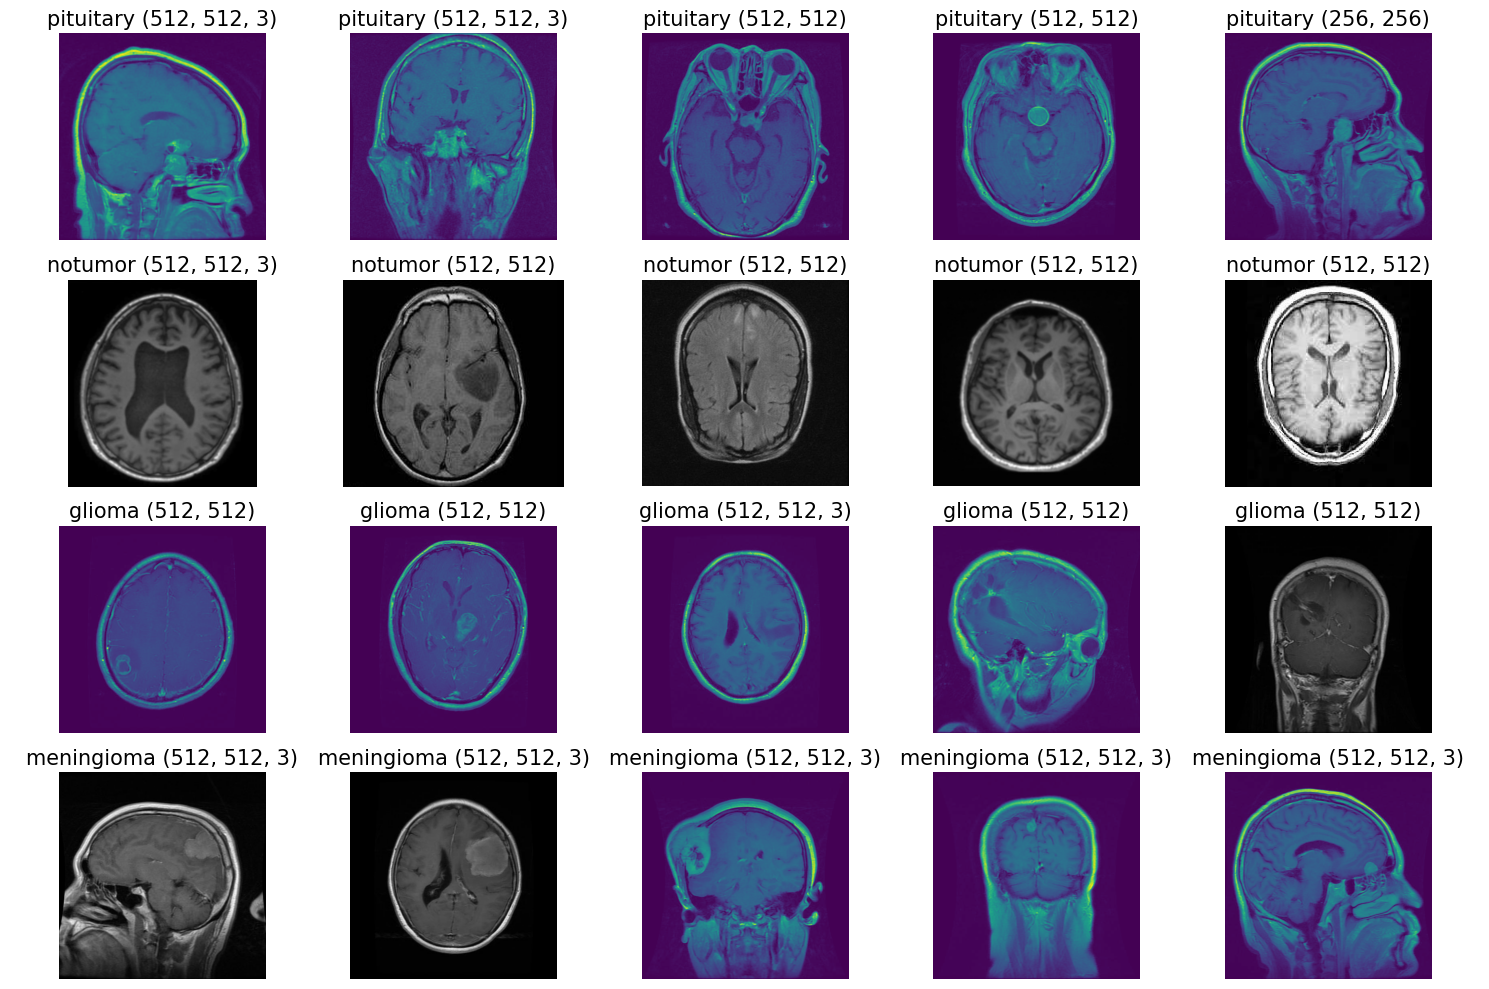

In [10]:
# Setup Data Paths
cwd = os.getcwd()
data_path = os.path.join(cwd,'data')
training_path = os.path.join(data_path,'Training')

# Initialize Data Variables
X_train = []
Y_train = []
img_shapes = []
label_names = []

# Load in Images and Labels
for label in os.listdir(training_path):
    label_names.append(label)
    label_path = os.path.join(training_path,label)
    for image in os.listdir(label_path):
        image_path = os.path.join(label_path,image)
        img_array = plt.imread(image_path)
        # img_array = cv.imread(image_path)

        # # Turn all Images to Gray Scale
        # img_array = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
        img_shapes.append(img_array.shape)
        X_train.append(img_array)
        Y_train.append(label)

# Shuffle Data for Randomization
np.random.seed(281)
indices = [i for i in range(0,len(X_train))]
shuffle_indices = np.random.permutation(indices)
X_train_shuffled = [X_train[i] for i in shuffle_indices]
Y_train_shuffled = [Y_train[i] for i in shuffle_indices]


# Plot Distribution of Image Shapes
img_shape_widths = [img[1] for img in img_shapes]
img_shape_heights = [img[0] for img in img_shapes]
plt.figure(figsize=(15,10))
plt.scatter(img_shape_widths, img_shape_heights)
plt.title("Image Shape Distribution")
plt.xlabel("Image Widths (px)")
plt.ylabel("Image Heights (px)")
plt.show()

# Channel Distribution
channel_size = [len(shape) for shape in img_shapes]
plt.figure(figsize = (5,5))
plt.hist(channel_size)
plt.title("Color Channel Distribution")
plt.xlabel("Number of Channels")


# Plot Example Images of Each Label
plt.figure(figsize = (15,10))
plt.axis('off')
column_indexer = 0
while column_indexer < 20:
    for label in label_names:
        index_pos = [i for i, x in enumerate(Y_train_shuffled) if x == label]
        for counter in range(0,5):
            image_index_value = index_pos[counter]
            plt.subplot(4,5,column_indexer+counter+1)
            plt.title(label +' ' + str(img_shapes[image_index_value]), fontsize=15)
            plt.axis('off')
            plt.imshow(X_train_shuffled[image_index_value])
        column_indexer = column_indexer + 5
plt.tight_layout()
plt.show()


### 2. Resolution/sizing Standardization

X_train shape: (5712, 128, 128, 1)
Y_train shape: (5712,)


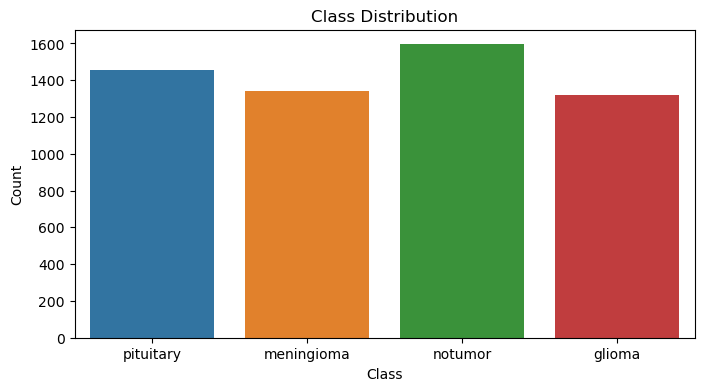

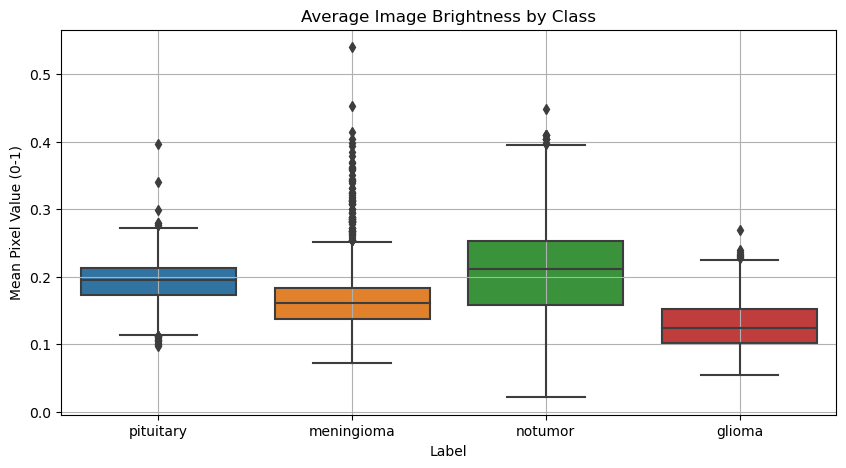

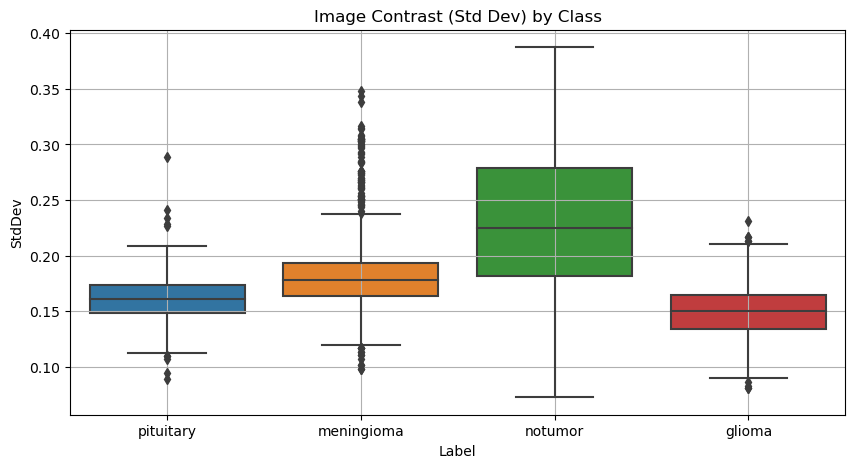

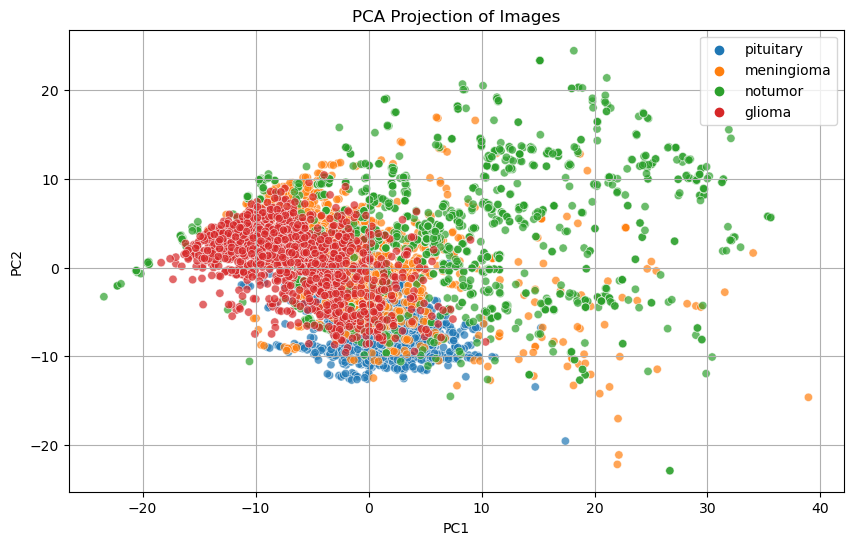

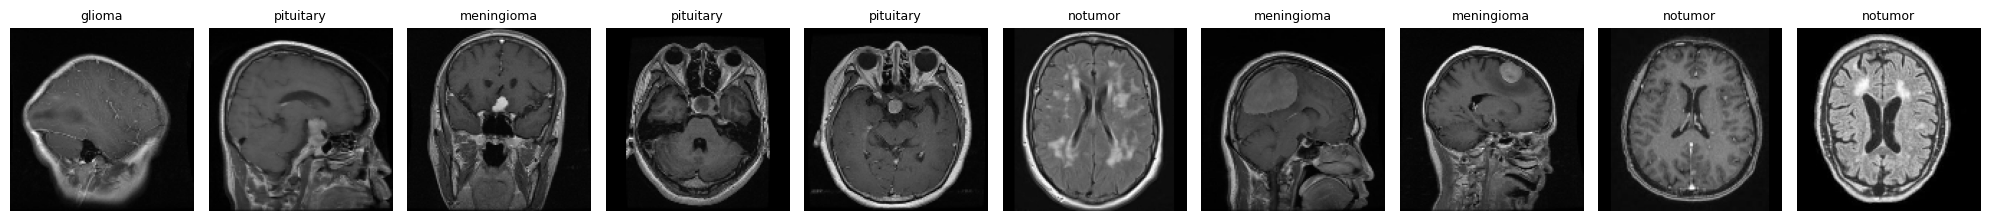

In [45]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from sklearn.decomposition import PCA
import hashlib

# Set data path
cwd = os.getcwd()
data_path = os.path.join(cwd, 'data')
training_path = os.path.join(data_path, 'Training')

# Resize with padding 
def resize_with_padding(img, target_size=(128, 128)):
    old_h, old_w = img.shape
    scale = min(target_size[1] / old_w, target_size[0] / old_h)
    new_w, new_h = int(old_w * scale), int(old_h * scale)
    resized = cv.resize(img, (new_w, new_h))
    top = (target_size[0] - new_h) // 2
    bottom = target_size[0] - new_h - top
    left = (target_size[1] - new_w) // 2
    right = target_size[1] - new_w - left
    return cv.copyMakeBorder(resized, top, bottom, left, right, cv.BORDER_CONSTANT, value=0)

# Load and preprocess images
X_train, Y_train, img_shapes, label_names = [], [], [], []

for label in os.listdir(training_path):
    label_names.append(label)
    label_path = os.path.join(training_path, label)
    for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)
        img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = resize_with_padding(img, target_size=(128, 128))
        img = img / 255.0
        X_train.append(img)
        Y_train.append(label)
        img_shapes.append(img.shape)

X_train = np.array(X_train)[..., np.newaxis]
Y_train = np.array(Y_train)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

# abel distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=Y_train)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Image brightness by class
brightness_data = [(label, np.mean(img)) for img, label in zip(X_train, Y_train)]
df_brightness = pd.DataFrame(brightness_data, columns=["Label", "Avg_Brightness"])

plt.figure(figsize=(10, 5))
sns.boxplot(x="Label", y="Avg_Brightness", data=df_brightness)
plt.title("Average Image Brightness by Class")
plt.ylabel("Mean Pixel Value (0-1)")
plt.grid(True)
plt.show()

# Image contrast (std dev) by class
contrast_data = [(label, np.std(img)) for img, label in zip(X_train, Y_train)]
df_contrast = pd.DataFrame(contrast_data, columns=["Label", "StdDev"])

plt.figure(figsize=(10, 5))
sns.boxplot(x="Label", y="StdDev", data=df_contrast)
plt.title("Image Contrast (Std Dev) by Class")
plt.grid(True)
plt.show()

#PCA projection (2D)
X_flat = X_train.reshape(len(X_train), -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=Y_train, alpha=0.7)
plt.title("PCA Projection of Images")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#Visualize 10 random images
plt.figure(figsize=(20, 5))
sample_idxs = random.sample(range(len(X_train)), 10)
for i, idx in enumerate(sample_idxs):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[idx].squeeze(), cmap='gray')
    plt.title(Y_train[idx], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()
